In [1]:
import os 
import pandas as pd 
import numpy as np 
from glob import glob
# from scipy import signal, fft
# from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

import scipy.signal
from scipy.signal.windows import hann

# import torch
# import torchaudio
# from torch.utils.data import Dataset

import tensorflow as tf 


import matplotlib.pyplot as plt
import librosa.display
from PIL import Image
import numpy as np

In [2]:
all_files = pd.read_csv('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/files.csv')
all_files.head()

,filename,train/test,sounds_amount
0,423_c.wav,train,24
1,113_c.wav,train,6
2,377_c.wav,train,5
3,25_g.wav,train,4
4,112_c.wav,train,9


In [3]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'train')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'train')])

(1023, 262)

In [4]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'test')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'test')])

(260, 61)

In [5]:
wav_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.wav')
csv_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.csv')
len(wav_files), len(csv_files)

(427, 427)

In [6]:
wav_train, wav_test = [], [] 
csv_train, csv_test = [], [] 

# for i in range(len(wav_files)):
for key, val in all_files.iterrows():
    if 'train' in val['train/test']:
        wav_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))
    else:
        wav_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))

In [7]:
len(wav_train), len(wav_test), len(csv_train), len(csv_test)

(1285, 321, 1285, 321)

In [8]:
total_category = {} 
for csv in csv_train:
    df = pd.read_csv(csv)
    
    try:
        unique_elements, counts = np.unique(df['category'].astype(str), return_counts=True)
        # element_counts_dict = dict(zip(unique_elements, counts))
        
        if len(unique_elements) < 1:
            continue
        
        for e, c in zip(unique_elements, counts):
            if e in total_category:
                total_category[e] += c
            else:
                total_category[e] = c
    except Exception as e:
        print(e)
            
    # break

total_category
        

{'s': 2819, 'm': 16, 'nan': 2152, 'b': 90, 'bc': 94, 'o': 1, 'a': 32, 'd': 2}

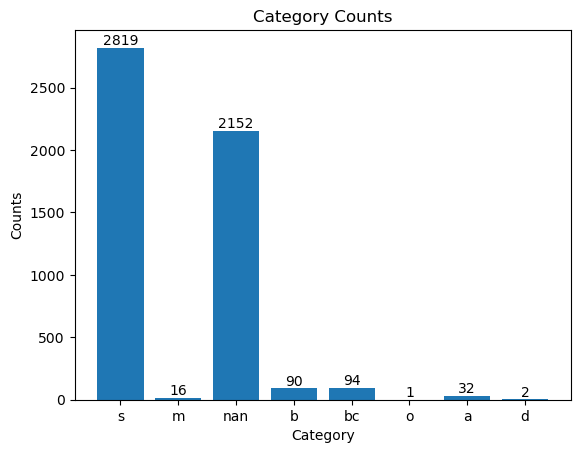

In [9]:
categories = list(total_category.keys())
counts = list(total_category.values())

# 막대 그래프 생성
plt.bar(categories, counts)

for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')


plt.xlabel('Category')  # X축 레이블
plt.ylabel('Counts')    # Y축 레이블
plt.title('Category Counts')  # 그래프 제목
plt.show()

In [10]:
df = pd.read_csv(csv_train[0])
df.head()

,start,end,fmin,fmax,category
0,0.014694,0.046621,165.242172,1903.133911,s
1,0.183039,0.213515,216.524216,1954.415894,s
2,0.339773,0.374603,216.524216,598.290649,s
3,0.583583,0.606803,119.658119,592.592590,s
4,0.879637,0.917370,153.846161,723.646729,s


In [11]:
from scipy.signal import butter, lfilter, spectrogram
from scipy.io import wavfile

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
signal, fs = librosa.load(wav_train[0], sr=44100)

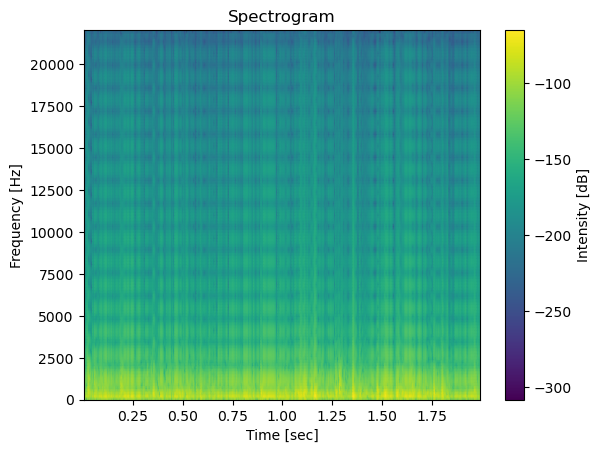

In [14]:
# 저역 통과 필터링 (컷오프 주파수 3000Hz)
filtered_signal = butter_lowpass_filter(signal, 1500, fs)

# 스펙트로그램 생성
frequencies, times, Sxx = spectrogram(filtered_signal, fs)

# 스펙트로그램 시각화
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [17]:
labels = pd.read_csv(wav_train[0].replace('wav', 'csv')) 
labels.head()

,start,end,fmin,fmax,category
0,0.014694,0.046621,165.242172,1903.133911,s
1,0.183039,0.213515,216.524216,1954.415894,s
2,0.339773,0.374603,216.524216,598.290649,s
3,0.583583,0.606803,119.658119,592.592590,s
4,0.879637,0.917370,153.846161,723.646729,s


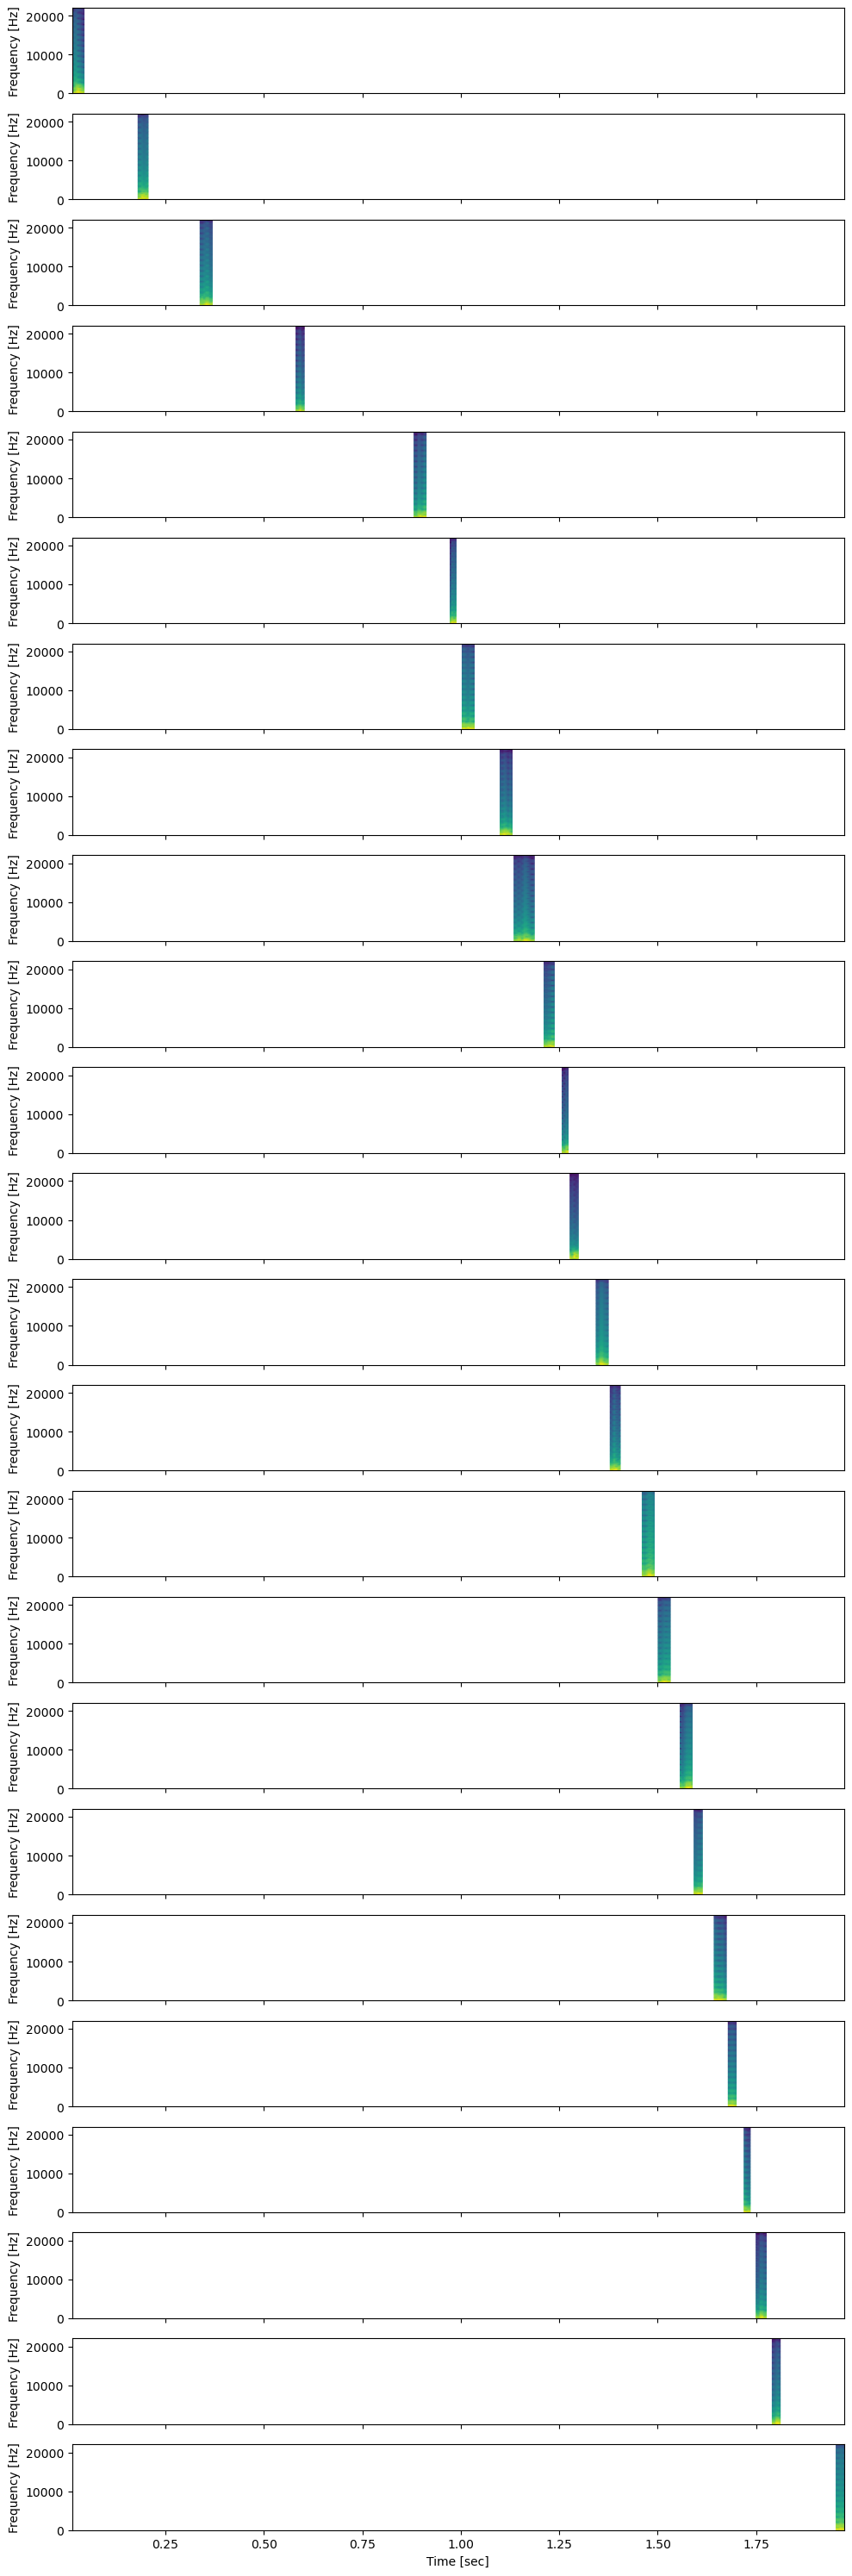

In [27]:
# 라벨링된 부분의 스펙트로그램 추출 및 시각화
fig, axs = plt.subplots(len(labels), 1, figsize=(10, 30), sharex=True, sharey=True)
spectrograms = []

for idx, row in labels.iterrows():
    start = row['start']
    end = row['end']
    
    # 라벨링된 시간에 해당하는 인덱스 찾기
    idx_start = np.argmin(np.abs(times - start))
    idx_end = np.argmin(np.abs(times - end))
    
    # 해당 부분의 스펙트로그램 데이터 추출
    Sxx_part = Sxx[:, idx_start:idx_end]
    times_part = times[idx_start:idx_end]
    frequencies_part = frequencies
    
    # 스펙트로그램 데이터 저장
    spectrograms.append({
        'label': row['category'],
        'frequencies': frequencies_part,
        'times': times_part,
        'Sxx': Sxx_part
    })

    
    # 시각화
    axs[idx].pcolormesh(times_part, frequencies, 10 * np.log10(Sxx_part), shading='gouraud')
    # axs[idx].set_title(f'Label: {label}')
    axs[idx].set_ylabel('Frequency [Hz]')

axs[-1].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

In [29]:
max_time_len = max([s['times'].shape[0] for s in spectrograms])
max_freq_len = max([s['frequencies'].shape[0] for s in spectrograms])

# 패딩을 적용하여 모든 스펙트로그램을 동일한 크기로 조정
padded_spectrograms = []

for spec in spectrograms:
    pad_time_len = max_time_len - spec['times'].shape[0]
    pad_freq_len = max_freq_len - spec['frequencies'].shape[0]
    
    # 시간 축과 주파수 축에 대해 패딩 적용
    padded_spec = np.pad(spec['Sxx'], ((0, pad_freq_len), (0, pad_time_len)), 'constant', constant_values=0)
    padded_spectrograms.append(padded_spec)

# NumPy 배열로 변환
padded_spectrograms_np = np.array(padded_spectrograms)
padded_spectrograms_np.shape


(24, 129, 11)

In [ ]:
# ---- 

In [30]:
spectrograms = []

for wav in wav_train:
    
    signal, fs = librosa.load(wav_train[0], sr=44100)
    filtered_signal = butter_lowpass_filter(signal, 1500, fs)

    frequencies, times, Sxx = spectrogram(filtered_signal, fs)
    
    csv = pd.read_csv(wav.replace('wav', 'csv'))

    for idx, row in csv.iterrows():
        start = row['start']
        end = row['end']
        
        # 라벨링된 시간에 해당하는 인덱스 찾기
        idx_start = np.argmin(np.abs(times - start))
        idx_end = np.argmin(np.abs(times - end))
        
        # 해당 부분의 스펙트로그램 데이터 추출
        Sxx_part = Sxx[:, idx_start:idx_end]
        times_part = times[idx_start:idx_end]
        frequencies_part = frequencies
        
        # 스펙트로그램 데이터 저장
        spectrograms.append({
            'label': row['category'],
            'frequencies': frequencies_part,
            'times': times_part,
            'Sxx': Sxx_part
        })
        
max_time_len = max([s['times'].shape[0] for s in spectrograms])
max_freq_len = max([s['frequencies'].shape[0] for s in spectrograms])

# 패딩을 적용하여 모든 스펙트로그램을 동일한 크기로 조정
padded_spectrograms = []
label_spectrograms = []

for spec in spectrograms:
    pad_time_len = max_time_len - spec['times'].shape[0]
    pad_freq_len = max_freq_len - spec['frequencies'].shape[0]
    
    # 시간 축과 주파수 축에 대해 패딩 적용
    padded_spec = np.pad(spec['Sxx'], ((0, pad_freq_len), (0, pad_time_len)), 'constant', constant_values=0)
    padded_spectrograms.append(padded_spec)
    
    label_spectrograms.append(spec['label'])

# NumPy 배열로 변환
padded_spectrograms_np = np.array(padded_spectrograms)
label_spectrograms = np.array(label_spectrograms)
padded_spectrograms_np.shape, label_spectrograms.shape

AttributeError: 'list' object has no attribute 'shape'